## Updater Algorithm Visualization 

This notebook simulates a series of bounty hunters who come up with different (g,h) pairs to submit as updates to the model. Each group g specified by a bounty hunter is a demographic group, and the h is a simple model trained on that group. For the paper, this was used on the ACS folktables dataset.

First, we load in all of our libraries:

In [1]:
import time
start_time = time.time()

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

import importlib
import copy

import updater
import model
import verifier

import warnings
warnings.filterwarnings('ignore')

Here we define our global parameters

In [3]:
classifier = "Decision Tree" # set to either "Decision Tree" or "Logistic Regression"
test_size = 0.2 #train-test split
dt_depth = 10 # setting decision tree training depth globally
conjunction = True #setting groups to be conjunctions in random cross-product version; if false runs with disjunctions

## Loading Data

Now, we have to load in the dataset.

In [4]:
# ACS specific flags

acs_task = 'employment' # options: employment, income, public_coverage, mobility, and travel_time.\
acs_year = 2018 # must be between 2014 and 2018
acs_states = ['NY'] # can be any list of state abbreviations.
acs_horizon='1-Year' # 1-Year or 5-Year
acs_survey='person' #'person' or 'household'

# for subsampling rows: can specify first and last of data to be pulled. currently pulling everything.
row_start = 0 
row_end = -1 #set to -1 if you want to pull the whole dataset

# for subsampling columns. note: can only subsample consecutive columns with current implementation in folktables
col_start=0
col_end=-1 #set to -1 if you want to pull the whole dataset

In [5]:
import acsDataParallel


[train_x, train_y, test_x, test_y, group_functions, group_indicators, min_age, mid_age] = acsDataParallel.get_data(
    test_size, acs_task, acs_year, acs_states,acs_horizon=acs_horizon, acs_survey=acs_survey, row_start = row_start,
    row_end = row_end, col_start=col_start, col_end=col_end)

To get a sense of what the data loooks like: 

For the column codes for the ACS data, see appendix B here https://arxiv.org/pdf/2108.04884.pdf. Briefly, the different categories are age (AGEP), education (SCHL), marital status (MAR), relationship (RELP), disability status (DIS), parent employee status (ESP), citizen status (CIT), mobility status (MIG), military service (MIL), ancestry record (ANC), nation of origin (NATIVITY), hearing difficulty (DEAR), visual dificulty (DEYE), learning disability (DREM), sex (SEX), and race (RAC1P).

Currently, the group functions generated for the ACS data are the 8 race categories, 2 sex categories, and 3 age groups, one of under 30-year-olds and one of 60+ year olds.

In [6]:
def print_group_info(x, groups, group_ind):
        indices = [g(x)==1 for g in groups]
        for i in range(len(groups)):
            print("Number of datapoints in group {}:".format(group_ind[i], len(indices[i])))
            

def print_all_info_table(x1, x2, groups, group_ind):
    indices = [g(x1) for g in groups]
    x1s = [x1[i] for i in indices]
    indices = [g(x2) for g in groups]
    x2s = [x2[i] for i in indices]
    nums = [x1.shape[0] + train_x.shape[0]]
    for i in range(len(groups)):
        nums.append(len(x1s[i]) + len(x2s[i]))
    print(*group_ind, sep= ' & ')
    print(*nums, sep=' & ')

print_all_info_table(test_x, train_x, group_functions, ['Total'] + group_indicators)

Total & White & Black or African American & Asian & Native Hawaiian, Native American, Native Alaskan, or Pacific Islander & Some Other Race & Two or More Races & Male & Female & Young & Middle & Old
196966 & 138473 & 24024 & 17030 & 10964 & 5646 & 829 & 95162 & 101804 & 68163 & 47469 & 81334


## Generating our initial model

Our initial model will be either logistic regression that's trained over all features or a decision tree over all features with depth 1.

In [7]:
initial_model = None
if classifier == "Logistic Regression":
    initial_model = LogisticRegression(penalty='none', max_iter = 2000)
elif classifier == "Decision Tree":
    initial_model = DecisionTreeClassifier(max_depth = 1, random_state=0) #setting random state for replicability
initial_model.fit(train_x, train_y);

We now can examine our initial model's loss

In [8]:
metrics.zero_one_loss(train_y, initial_model.predict(train_x))

0.344566293503922

## Generating our bounty hunters' inputs

We want to simulate a series of bounty hunters, each who propose a group function *g* and a model *h* which performs better on that group. Specifically, we first imagine a set of bounty hunters who propose models that are trained only on a specific racial group, then bounty hunters who train groups based on sex, then age categories.

First, we need to define the *g* functions. A given *g_i(x)* should return 1 if *x* is a member of the group that the ith bounty hunter is targeting, and 0 otherwise. We assume that these groups have been predefined, using the features of the dataset.

Next, we need to generate regression models that are trained just over the portion of the data that each group function applies to. We're going to be reusing this code for later sets of groups, so build a helper function that does it in general.

In [9]:
def bounty_hunter_models(x, y, g_functions):
    # learn the indices first
    indices = [g(x)==1 for g in g_functions]
    # then pull the particular rows from the dataframe
    training_xs = [x[i] for i in indices]
    training_ys = [y[i] for i in indices]

    ms = []
    for i in range(len(training_xs)):
        if classifier == "Logistic Regression":
            log_reg = LogisticRegression(penalty='none', max_iter = 2000)
            log_reg.fit(training_xs[i], training_ys[i])
            ms.append(log_reg.predict)
        elif classifier == "Decision Tree":
            dt = DecisionTreeClassifier(max_depth = dt_depth, random_state=0) #setting random state for replicability
            dt.fit(training_xs[i], training_ys[i])
            ms.append(dt.predict)
    return ms

In [10]:
# now, generate the models using the group functions
models = bounty_hunter_models(train_x, train_y, group_functions)

# Running the Model Updates

We now run the updater, which incorporates all of the bounty hunters' updates iteratively, and store the errors of each group at each step.

In [11]:
def run_updates(g_functions, models_to_update, g_indicators, file_name):
    # stick the gs and hs into a form that the updater accepts
    bounty_hunters = [[g_functions[i], models_to_update[i], g_indicators[i]] for i in range(len(g_functions))]

    all_groups = [lambda x: np.ones(len(x),dtype=bool)] + g_functions
    print("Building initial model")
    # build the initial model 
    f = model.PointerDecisionList(initial_model.predict, all_groups)

    #  recording the errors of the initial model
    f.test_errors[0] = updater.measure_all_group_errors(f, all_groups, test_x, test_y)
    f.train_errors[0] = updater.measure_all_group_errors(f, all_groups, train_x, train_y)
    
    # run the updater
    updated_pdls = [copy.deepcopy(f)]
    print("Measuring group errors of initial model on training data")

    i = 0
    for b in bounty_hunters:
        print("Running on group {}/{}".format(i+1, len(bounty_hunters)))
        print("Group running on {}".format(g_indicators[i]))
        # check if we want to bother with the update or not
        if verifier.is_proposed_group_good(f, test_x, test_y, b[1], b[0]):
            # the update step:
            updater.iterative_update(f, b[1], b[0], train_x, train_y, test_x, test_y, b[2], all_groups, g_indicators)
            # create a copy of the model at this stage for later visualization purposes
            updated_pdls.append(copy.deepcopy(f))
        # if the update didn't help, just copy the errors and updated_pdls at this round.
        else:
            print("Group {} is rejected".format(g_indicators[i]))
            updated_pdls.append(copy.deepcopy(f))
            f.num_rounds += 1
            f.track_rejects.append(0)
            
        i+=1
        print(".....................................................")
    # store our errors for later use
    u_test_errors = pd.DataFrame(f.test_errors)
    u_test_errors.to_csv(file_name + '.csv')
    
    u_train_errors = pd.DataFrame(f.train_errors)
    
    return [u_test_errors, u_train_errors, updated_pdls]

We'd like to shuffle the main groups. The next block does this, and runs the update on the shuffled version. In order to randomize the output, change the value of the random seed in the first line. 

In [12]:
# change the next line to change the random seed. We use this instead of random.Seed as random.Seed is no longer the
# best practice method as the random.seed function affects randomization globally and can mess with imported
# packages that use randomness.
rng = np.random.default_rng(12345)
r_indices = np.arange(len(group_functions))
rng.shuffle(r_indices)
r_group_functions = [group_functions[i] for i in r_indices]
r_models = [models[i] for i in r_indices]
r_group_indicators = [group_indicators[i] for i in r_indices]

[test_errors, train_errors, pdls] = run_updates(r_group_functions, r_models, r_group_indicators, 'updater-errors-simple')

Building initial model
Measuring group errors of initial model on training data
Running on group 1/11
Group running on Some Other Race
Error of current model on proposed group: 0.231304347826087
Error of h trained on proposed group: 0.1660869565217391
Running iterative update for group: Some Other Race
Model groups prior to update: 
['Total']
Group errors on test set prior to update (over all groups)
[0.34660101 0.23130435 0.16918915 0.37985288 0.30500689 0.38035302
 0.56818322 0.31057465 0.35399224 0.30313691 0.22282035 0.37426901]
Group errors after new group has been prepended to PDL:
[0.3446971620043662, 0.1660869565217391]
Group Weights:
[1.0, 0.02919226278113418]
No repairs needed.
Group errors of every group, even those not yet introduced, on test set after repairs:
['Total', 'Some Other Race', 'Young', 'Black or African American', 'Native Hawaiian, Native American, Native Alaskan, or Pacific Islander', 'Female', 'Old', 'Male', 'White', 'Asian', 'Middle', 'Two or More Races']
[0

# Visualizing the Group Errors

First, we have to clean up our error tables to remove the rows and columns of the updates that were rejected, since we give no monotonicity guarantees for them.

In [13]:
# label the dataframe to make easier to read
test_errors.columns = ['Total'] + r_group_indicators
test_errors.index = ['Total'] + r_group_indicators

train_errors.columns = ['Total'] + r_group_indicators
train_errors.index = ['Total'] + r_group_indicators

test_errors

,Total,Some Other Race,Young,Black or African American,"Native Hawaiian, Native American, Native Alaskan, or Pacific Islander",Female,Old,Male,White,Asian,Middle,Two or More Races
Total,0.346601,0.231304,0.169189,0.379853,0.305007,0.380353,0.568183,0.310575,0.353992,0.303137,0.222820,0.374269
Some Other Race,0.344697,0.166087,0.168531,0.379853,0.305007,0.378190,0.564428,0.308948,0.353992,0.303137,0.222293,0.374269
Young,0.331548,0.164348,0.130657,0.359215,0.282040,0.369782,0.564428,0.290737,0.343010,0.284960,0.222293,0.374269
Black or African American,0.309895,0.164348,0.130657,0.184920,0.282040,0.347313,0.520901,0.269955,0.343010,0.284960,0.206882,0.374269
"Native Hawaiian, Native American, Native Alaskan, or Pacific Islander",0.304742,0.164348,0.130657,0.184920,0.188792,0.341167,0.510682,0.265862,0.343010,0.284960,0.202977,0.374269
Female,0.228817,0.151304,0.130657,0.182060,0.186955,0.194110,0.334729,0.265862,0.242905,0.232776,0.188938,0.269006
Old,0.180484,0.146087,0.130657,0.181038,0.182820,0.193520,0.217509,0.166570,0.179479,0.197596,0.188938,0.187135
Male,0.175610,0.146087,0.130657,0.181038,0.182820,0.193520,0.215908,0.156494,0.172774,0.196717,0.171417,0.163743
White,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Asian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# identify the rows that have nans
row_has_NaN = test_errors.isnull().any(axis=1)

ind = []
for i in range(len(row_has_NaN)):
    if row_has_NaN[i]:
        ind.append(i)

# drop the columns of updates that correspond to these 
p_test_errors = test_errors.drop(columns = row_has_NaN.keys()[ind])
# drop the rows of updates that correspond to these
p_test_errors = p_test_errors.dropna()

# identify the rows that have nans
row_has_NaN = train_errors.isnull().any(axis=1)

ind = []
for i in range(len(row_has_NaN)):
    if row_has_NaN[i]:
        ind.append(i)

# drop the columns of updates that correspond to these 
p_train_errors = train_errors.drop(columns = row_has_NaN.keys()[ind])
# drop the rows of updates that correspond to these
p_train_errors = p_train_errors.dropna()

## Visualizing the Test Errors

These should be monotone, since they are what were used to make the repairs. 

Since we make no monotonicity guarantees about the updates that were rejected, we remove that data from the data that is to be plotted:

Text(0.5, 1.0, 'ACS Group Errors Throughout Update Algorithm for Test Data')

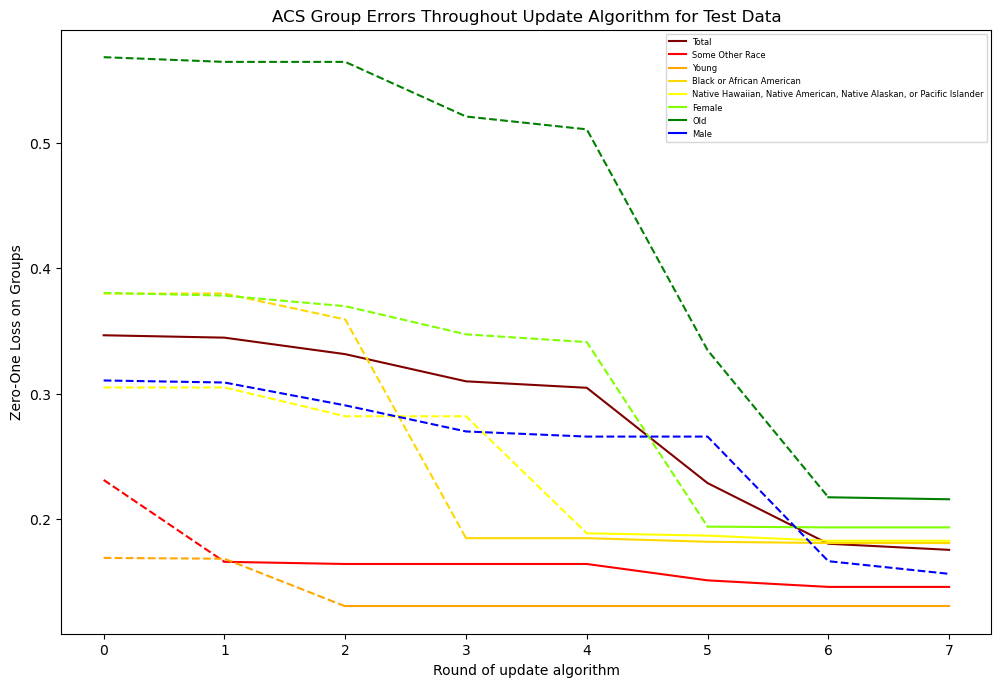

In [15]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger

group_indicators_for_plotting = p_test_errors.columns

# plot the errors
j=0
colors = ['maroon', 'red', 'orange', 'gold', 'yellow',
          'chartreuse', 'green', 'blue', 'deepskyblue',
          'purple', 'plum',  'pink', 'gray', 'fuchsia', 'black']
xs = np.arange(len(group_indicators_for_plotting))
for group in group_indicators_for_plotting: #plot all groups
    plt.plot(xs[j:],p_test_errors[group][j:].values, label=group, color=colors[j])
    plt.plot(xs[:j+1],p_test_errors[group][:j+1].values, linestyle='--', color=colors[j])
    j+=1
plt.xlabel('Round of update algorithm')
plt.ylabel("Zero-One Loss on Groups")
plt.legend(prop={'size': 6})
plt.title("ACS Group Errors Throughout Update Algorithm for Test Data")

## Visualizing the Training Error

First we have to determine what the test errors are for each group.

Text(0.5, 1.0, 'AcS Group Errors Throughout Update Algorithm for Training Data')

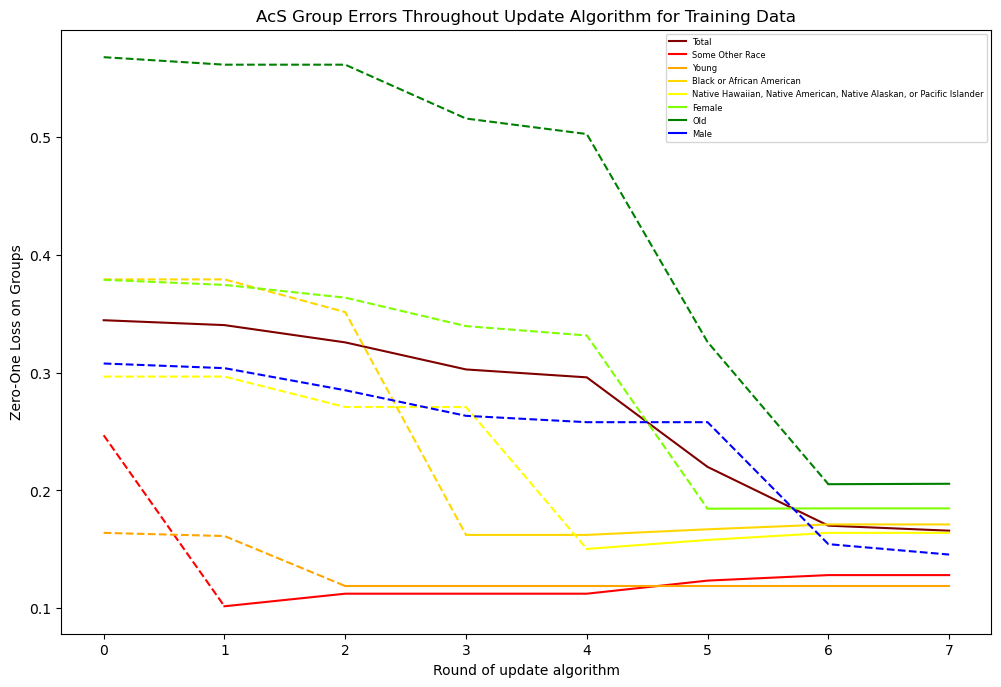

In [16]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger

group_indicators_for_plotting = p_train_errors.columns

# plot the errors
j=0
colors = ['maroon', 'red', 'orange', 'gold', 'yellow',
          'chartreuse', 'green', 'blue', 'deepskyblue',
          'purple', 'plum',  'pink', 'gray', 'fuchsia', 'black']
xs = np.arange(len(group_indicators_for_plotting))
for group in group_indicators_for_plotting:
    plt.plot(xs[j:],p_train_errors[group][j:].values, label=group, color=colors[j])
    plt.plot(xs[:j+1],p_train_errors[group][:j+1].values, linestyle='--', color=colors[j])
    j+=1
plt.xlabel('Round of update algorithm')
plt.ylabel("Zero-One Loss on Groups")
plt.legend(prop={'size': 6})
plt.title("AcS Group Errors Throughout Update Algorithm for Training Data")

## Visualizing training-test difference

Text(0.5, 1.0, 'ACS Absolute Difference in Error Between Test and Training Data')

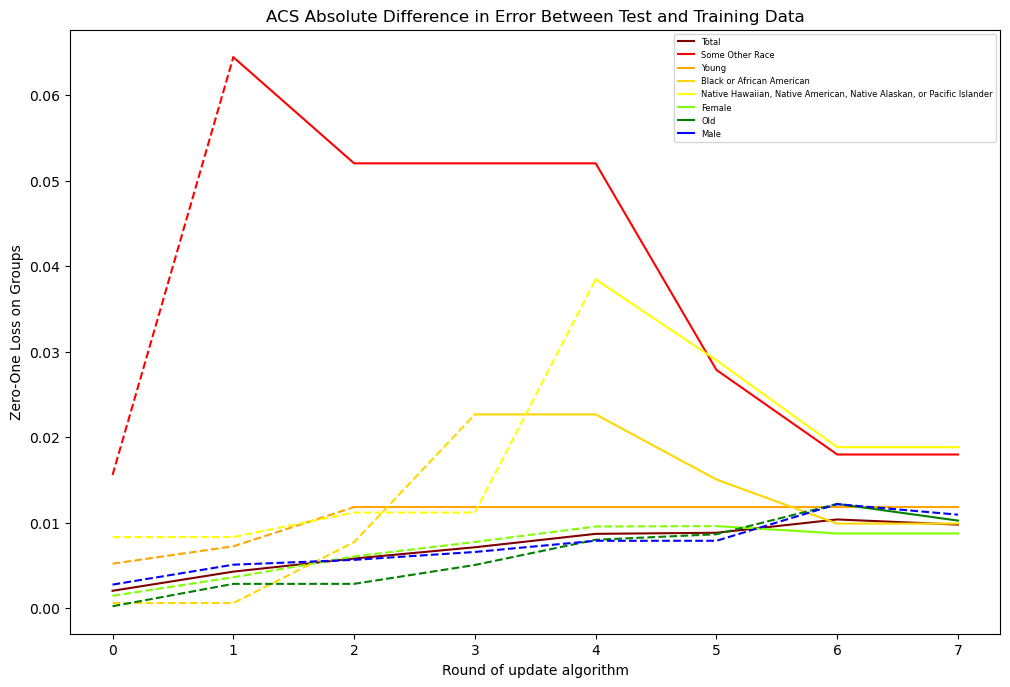

In [17]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k') # make plot bigger

group_indicators_for_plotting = p_train_errors.columns

# plot the errors
j=0
colors = ['maroon', 'red', 'orange', 'gold', 'yellow',
          'chartreuse', 'green', 'blue', 'deepskyblue',
          'purple', 'plum',  'pink', 'gray', 'fuchsia', 'black']
xs = np.arange(len(group_indicators_for_plotting))
for group in group_indicators_for_plotting:
    plt.plot(xs[j:],abs(p_test_errors[group][j:].values - p_train_errors[group][j:].values), label=group, color=colors[j])
    plt.plot(xs[:j+1],abs(p_test_errors[group][:j+1].values - p_train_errors[group][:j+1].values), linestyle='--', color=colors[j])
    j+=1
plt.xlabel('Round of update algorithm')
plt.ylabel("Zero-One Loss on Groups")
plt.legend(prop={'size': 6})
plt.title("ACS Absolute Difference in Error Between Test and Training Data")

In [18]:
finish_time = time.time()

In [19]:
delta_time = finish_time - start_time
print(delta_time)

14.465670585632324
